In [80]:
import numpy as np
import torch
import sklearn
import chainer_chemistry

In [81]:
import torch
from torch import nn
import warnings
import numpy as np
import itertools
warnings.simplefilter(action='ignore', category=UserWarning)
from chainer_chemistry import datasets
from chainer_chemistry.dataset.preprocessors.ggnn_preprocessor import GGNNPreprocessor

In [82]:

"""
    load data
"""
dataset, dataset_smiles = datasets.get_qm9(GGNNPreprocessor(kekulize=True), return_smiles=True,
                                           target_index=np.random.choice(range(133000), 100, False))

100%|██████████| 100/100 [00:00<00:00, 2786.30it/s]


In [168]:

"""
    load data
"""
dataset2, dataset_smiles2 = datasets.get_qm9(GGNNPreprocessor(kekulize=True), return_smiles=True,
                                           target_index=np.random.choice(range(133000), 1000, False))

100%|██████████| 1000/1000 [00:00<00:00, 3287.95it/s]


In [169]:
V = 9
atom_types = [6, 8, 7, 9, 1]

def adj(x):
    x = x[1]
    adjacency = np.zeros((V, V)).astype(float)
    adjacency[:len(x[0]), :len(x[0])] = x[0] + 2 * x[1] + 3 * x[2]
    return torch.tensor(adjacency)


def sig(x):
    x = x[0]
    atoms = np.ones((V)).astype(float)
    atoms[:len(x)] = x
    out = np.array([int(atom == atom_type) for atom_type in atom_types for atom in atoms]).astype(float)
    return torch.tensor(out).reshape(5, len(atoms)).T


def target(x):
    x = x[2]
    return torch.tensor(x)


adjs = torch.stack(list(map(adj, dataset)))
sigs = torch.stack(list(map(sig, dataset)))
prop = torch.stack(list(map(target, dataset)))[:, 5]


In [170]:


class GCN:
    """
        Graph convolutional layer
    """
    def __init__(self, in_features, out_features):
        # -- initialize weight
        self.in_features = in_features
        self.out_features = out_features
        # self.W = torch.empty(in_features, out_features, dtype=torch.float64)
        # nn.init.xavier_normal_(self.W)
        # self.W = self.W.requires_grad_()
        self.W = nn.Parameter(torch.DoubleTensor(in_features, out_features))
        nn.init.xavier_normal_(self.W)

        # -- non-linearity
        self.relu = nn.ReLU()

    def __call__(self, A, H):
        # -- GCN propagation rule
        A += torch.eye(A.shape[0], dtype=torch.float64)
        D = torch.diag(1. / torch.sqrt(torch.sum(A, axis=1)))
        # D2 = torch.diag(torch.sqrt(torch.sum(A, axis=1)))
        H = self.relu(D @ A @ D @ H @ self.W)
        return H


class GraphPooling:
    """
        Graph pooling layer
    """
    def __init__(self):
        pass

    def __call__(self, H):
        # -- multi-set pooling operator
        # This pooling layer should sum the node features as graph features
        h = torch.sum(H,dim=0)
        return h

        
class MyModel(nn.Module):
    """
        Regression  model
    """
    def __init__(self):
        super(MyModel, self).__init__()
        # -- initialize layers
        self.GCN = GCN(5,16)
        self.pooling = GraphPooling()
        self.linear = nn.Linear(16,1,dtype=torch.float64)

    def forward(self, A, h0):
        # A:  N x N
        # h0: N x in
        # output: N x out
        H0=self.GCN(A,h0)
        H1=self.pooling(H0)
        H2=self.linear(H1)
        return H2
       


In [171]:
model = MyModel()
pred = model.forward(adjs[0],sigs[0])
print(adjs[0].dtype,sigs[0].dtype,pred.dtype,prop[0])
print(model)

torch.float64 torch.float64 torch.float64 tensor(-0.2732)
MyModel(
  (linear): Linear(in_features=16, out_features=1, bias=True)
)


In [192]:
model = MyModel()
MyLoss = []
criterion = nn.MSELoss()  
optimizer = torch.optim.SGD([{'params': model.GCN.W},
                {'params': model.linear.parameters()}], lr=0.1)
# -- update parameters
for epoch in range(1):
    for i in range(100):

        # -- predict
        pred = model.forward(adjs[i], sigs[i])

        # -- loss
        loss = criterion(pred, prop[i].to(torch.float64)) # RMSE
        MyLoss.append(loss)
        if i%5 == 1:
            print(f'epoch: {i:3}  loss: {loss.item():10.8f}')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # -- optimize

# -- plot loss


epoch:   1  loss: 9.12081319
epoch:   6  loss: 0.01892377
epoch:  11  loss: 0.26137610
epoch:  16  loss: 0.05453241
epoch:  21  loss: 0.00108972
epoch:  26  loss: 0.00000478
epoch:  31  loss: 0.00001484
epoch:  36  loss: 0.00105452
epoch:  41  loss: 0.05414137
epoch:  46  loss: 0.00033467
epoch:  51  loss: 0.00000969
epoch:  56  loss: 0.00124499
epoch:  61  loss: 0.00451642
epoch:  66  loss: 0.00028055
epoch:  71  loss: 0.00031269
epoch:  76  loss: 0.00302445
epoch:  81  loss: 0.00013801
epoch:  86  loss: 0.00139607
epoch:  91  loss: 0.00002021
epoch:  96  loss: 0.00001260


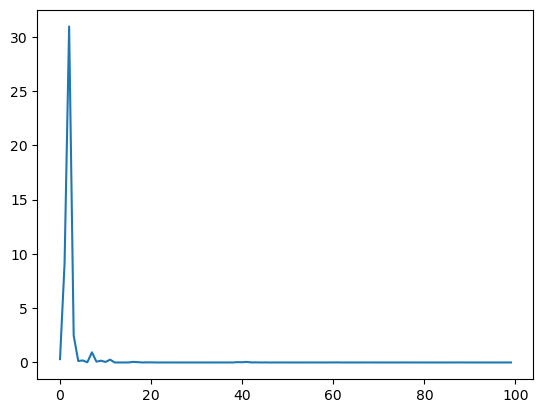

In [193]:
import matplotlib.pyplot as plt
with torch.no_grad():
    plt.plot(range(len(MyLoss)),MyLoss)

In [195]:
prediction = []
targets = []
for i in range(1000):
    pred = model.forward(adj(dataset2[i]), sig(dataset2[i]))
    prediction.append(pred)
    tar = dataset2[i][2][5]
    targets.append(tar)
    print(f'pred: {pred}  target: {tar}')
    


pred: tensor([-0.2049], dtype=torch.float64, grad_fn=<AddBackward0>)  target: -0.2547999918460846
pred: tensor([-0.2333], dtype=torch.float64, grad_fn=<AddBackward0>)  target: -0.2529999911785126
pred: tensor([-0.2446], dtype=torch.float64, grad_fn=<AddBackward0>)  target: -0.24150000512599945
pred: tensor([-0.2254], dtype=torch.float64, grad_fn=<AddBackward0>)  target: -0.2320999950170517
pred: tensor([-0.2363], dtype=torch.float64, grad_fn=<AddBackward0>)  target: -0.24770000576972961
pred: tensor([-0.2454], dtype=torch.float64, grad_fn=<AddBackward0>)  target: -0.25110000371932983
pred: tensor([-0.2540], dtype=torch.float64, grad_fn=<AddBackward0>)  target: -0.30000001192092896
pred: tensor([-0.2358], dtype=torch.float64, grad_fn=<AddBackward0>)  target: -0.2409999966621399
pred: tensor([-0.2240], dtype=torch.float64, grad_fn=<AddBackward0>)  target: -0.23669999837875366
pred: tensor([-0.2424], dtype=torch.float64, grad_fn=<AddBackward0>)  target: -0.20749999582767487
pred: tensor([

In [196]:
print(targets[0].dtype)
torch.is_tensor(targets[0])

float32


False

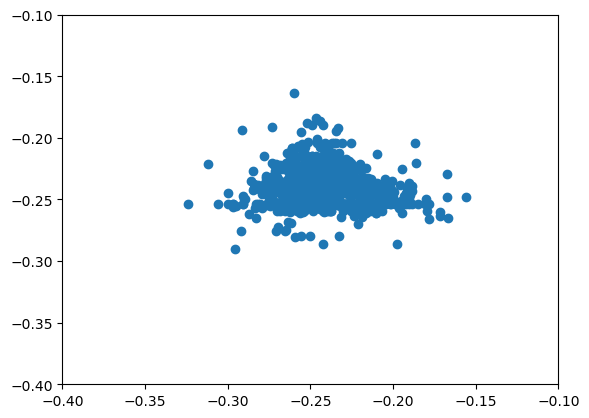

In [200]:
with torch.no_grad():
    plt.xlim([-0.4, -0.1])
    plt.ylim([-0.4, -0.1])
    plt.scatter(targets,prediction)